# ZILLOW HOUSING DATA TIME SERIES ANALYSIS

## BUSINESS UNDERSTANDING 

### PROBLEM STATEMENT

Real investment firms weigh on many factors when deciding on which investment to make. These firms’ goals are to enhance their decision making processes. With historical real estate market data, the challenge is to leverage data science techniques to identify potential investment opportunities and helping the real estate firms in making informed investment decisions.

### OBJECTIVES
Main Objectives:
* Identify the 5 best zip codes.

Secondary Objectives:
* Predict the prices of the best 5 zipcodes. 

In [2]:
!pip install prophet

!pip install pmdarima


In [3]:
## Importing the necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
from functions import *  
import numpy as np
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split



import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


## DATA UNDERSTANDING

#### Load the dataset

This project uses data from ZIllow housing data,  found [here](https://www.zillow.com/research/data/)

In [4]:
data = pd.read_csv("data/zillow_data.csv")
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
len(data["RegionName"].unique())

14723

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


The dataset contains 14723 rows and 272 columns.    
Each of the row is a unique zipcode.    
The dataset as seen is in a Wide format. Columns 1-7 show the different properties of a house.    
However,  column 8 to column 272 are actual time series values. The columns refer to the median house sales values for their respective month and year.      
This format makes the dataframe intuitive and easy to read. However problems with this dataset may come in when it comes to actually learning from the data. We'll deal with that when we get there.   
The first 7 columns represent:
* RegionID - The Regional ID for the region where a house is located.
* RegionName - The Zipcode. 
* City - The City of a particular house. 
* State - The state in which a home is in. 
* Metro - The metropolitan area where the home is found. 
* CountyName - The county where the home is in. 
* SizeRank - Hapa sijui. 

Drop the unnecessary columns and rename the RegionName to zipcode

In [7]:
#  drop the unnecessary columns
data.drop(["RegionID", "Metro", "SizeRank", "CountyName"], axis=1, inplace=True)

# rename the RegionName to ZipCode
data.rename({"RegionName":"ZipCode"}, axis=1 , inplace=True)

Check for missing values

In [8]:
data.isna().sum()

ZipCode       0
City          0
State         0
1996-04    1039
1996-05    1039
           ... 
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 268, dtype: int64

As is always the case with time series data, we have missing values. 

In [9]:
# drop the missing values
data.dropna(axis=0, inplace=True)

In [10]:
data.isna().sum().sum()

0

### Choosing zipcodes

We will use Return On Investment (ROI) and Compound Annual Growth Rate (CAGR) as our metrics  to decide the best zipcodes.          
ROI measures the profitability while CAGR checks the risk.      
We will measure the best zipcodes for the last 10 years.    
We will do this by adding roi column and cagr column to calculate the return on investment and the cagr respectively for every zipcode.  

In [11]:
# copy the dataframe
sample_data = data.copy()

#add an roi column for the last 10 years
sample_data["roi"] = (sample_data["2018-04"] - sample_data["2008-04"]) / sample_data["2008-04"] * 100

# add cagr column for the last 10 years
sample_data["cagr"] = (((sample_data["2018-04"] / sample_data["2008-04"]) ** (1/10)) -1) * 100
sample_data.head()

,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
0,60657,Chicago,IL,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,...,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,19.130736,1.765925
1,75070,McKinney,TX,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,312500,314100,315000,316600,318100,319600,321100,321800,52.367424,4.301178
2,77494,Katy,TX,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,320200,320400,320800,321200,321200,323000,326900,329900,32.224449,2.832685
3,60614,Chicago,IL,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,...,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,14.238266,1.340061
4,79936,El Paso,TX,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,120000,120300,120300,120300,120300,120500,121000,121500,-5.300078,-0.543090


We now choose the  best 5 zipcodes depending on the both the ROI and CAGR

In [12]:
# Top 5 based on ROI
top_5_roi = sample_data.nlargest(5, 'roi')

top_5_roi


,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
6563,15201,Pittsburgh,PA,34400.0,34600.0,34700.0,34700.0,34800.0,34800.0,34700.0,...,166100,167600,169000,170400,171400,173900,179700,185200,166.474820,10.297487
2580,94043,Mountain View,CA,291700.0,294000.0,296400.0,298900.0,301400.0,304100.0,306800.0,...,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,160.110317,10.031177
1155,11222,New York,NY,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,157.611136,9.924997
5738,94301,Palo Alto,CA,709500.0,711900.0,715000.0,719000.0,723900.0,729800.0,736900.0,...,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,156.475222,9.876430
117,11211,New York,NY,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,147.968845,9.506453


In [13]:
# Top 5 based on CAGR
top_5_cagr = sample_data.nlargest(5, 'cagr')

top_5_cagr

,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
6563,15201,Pittsburgh,PA,34400.0,34600.0,34700.0,34700.0,34800.0,34800.0,34700.0,...,166100,167600,169000,170400,171400,173900,179700,185200,166.474820,10.297487
2580,94043,Mountain View,CA,291700.0,294000.0,296400.0,298900.0,301400.0,304100.0,306800.0,...,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,160.110317,10.031177
1155,11222,New York,NY,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,157.611136,9.924997
5738,94301,Palo Alto,CA,709500.0,711900.0,715000.0,719000.0,723900.0,729800.0,736900.0,...,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,156.475222,9.876430
117,11211,New York,NY,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,147.968845,9.506453


The zipcodes with the best roi are still the zipcodes with the best cagr. 

#### CONVERTING THE DATASET TO WIDE FORMAT

We will convert the dataset to a wide format and make the time column the index for easier manipulation of the dataframe. 

In [14]:
# As seen below, the data is in a wide format,   we need to convert the data to a long format
data.head()

,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [15]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index("time", inplace=True)
    melted_data = melted.groupby("time").aggregate({'value' : 'mean'})
    return melted_data

melted_data = melt_data(data) 
melted_data.head()


,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


We now have the long format of our time series data. Additionally, the data is now aggregated in months.  

In [16]:
#  check the home prices summary statistics 
melted_data.describe()

,value
count,265.000000
mean,208049.936905
std,48821.725343
min,118299.123063
25%,168655.042385
50%,216703.719673
75%,248048.589594
max,293867.553347


The average home price is  $ 208049 for the past 22 years. 
This is with a standard deviation of 48821 over the same period

Let's get our best 5 zipcodes

In [17]:
def melt_data2(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index("time", inplace=True)
    return melted

melted_data2 = melt_data2(data) 
melted_data2.head()
# Get every time series entry whose zipcode is our top 5 zipcodes.

bet_5_zipcodes_df = melted_data2[melted_data2["ZipCode"].isin(list(top_5_cagr["ZipCode"]))]
bet_5_zipcodes_df

,ZipCode,City,State,value
time,,,,
1996-04-01,11211,New York,NY,133200.0
1996-04-01,11222,New York,NY,149200.0
1996-04-01,94043,Mountain View,CA,291700.0
1996-04-01,94301,Palo Alto,CA,709500.0
1996-04-01,15201,Pittsburgh,PA,34400.0
...,...,...,...,...
2018-04-01,11211,New York,NY,1623700.0
2018-04-01,11222,New York,NY,1721100.0
2018-04-01,94043,Mountain View,CA,2074900.0


### EDA AND DATA VISUALIZATION.

What is the trend of the average home prices in our dataset?
We will plot the time series of the home prices mean over the years, 1996 - 2018

We can check the states where these best 5 zipcodes are found

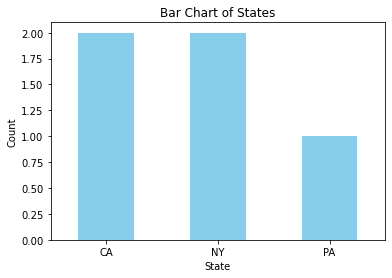

In [18]:
state_counts = top_5_cagr["State"].value_counts()

# Plot the bar chart
state_counts.plot(kind='bar', rot=0, color='skyblue')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Bar Chart of States')
plt.show()

Our best zipcodes are found in only three states.           
There are two zipcodes from both CA and NY while PA has one zip code. 

We can plot the time series plot of the best    5 zipcodes. 

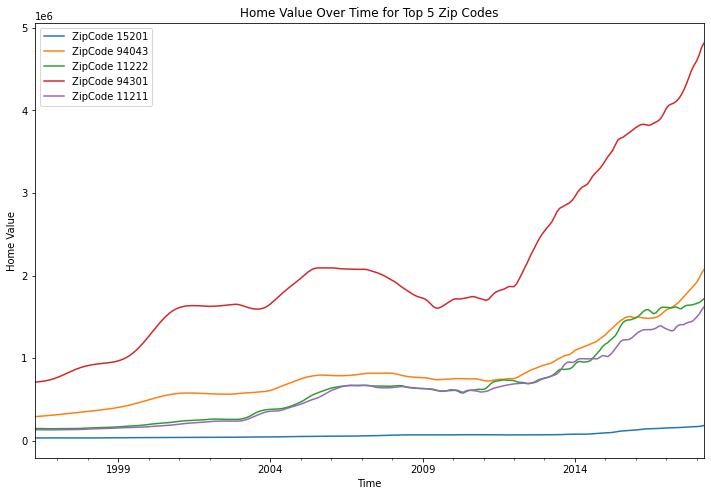

time
1996-04-01     133200.0
1996-05-01     132900.0
1996-06-01     132500.0
1996-07-01     132200.0
1996-08-01     131800.0
                ...    
2017-12-01    1463100.0
2018-01-01    1496100.0
2018-02-01    1531100.0
2018-03-01    1581900.0
2018-04-01    1623700.0
Name: value, Length: 265, dtype: float64

In [19]:
bet_5_zipcodes_list = top_5_cagr["ZipCode"].unique()
plt.figure(figsize=(12, 8))

for zipcode in bet_5_zipcodes_list:
    time_data = bet_5_zipcodes_df[bet_5_zipcodes_df["ZipCode"] == zipcode]["value"]
    time_data.plot(label=f'ZipCode {zipcode}')
time_data
plt.title('Home Value Over Time for Top 5 Zip Codes')
plt.xlabel('Time')
plt.ylabel('Home Value')
plt.legend()
plt.show()
time_data

What are the  10 year ROI and the CAGR for the best 5 zipcodes ?
Let's plot the ROI against the CAGR for the best 5 zipcodes.

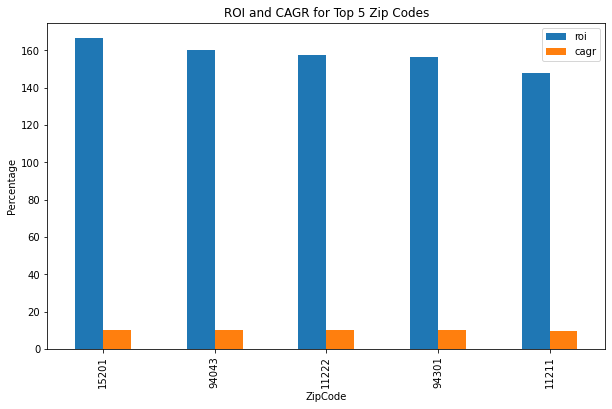

In [20]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both ROI and CAGR on the same axes
top_5_cagr.plot.bar(x="ZipCode", y=["roi", "cagr"], ax=ax)

# Set labels and title
ax.set_xlabel('ZipCode')
ax.set_ylabel('Percentage')
ax.set_title('ROI and CAGR for Top 5 Zip Codes')

# Show the plot
plt.show()

The property's ROI is significantly high compared to the CAGR. 


ROI as a measure of percentage increase of a property's value compared to the initial investment value, increases greatly compared to the CAGR, the average annual growth rate over a specified period, which provides a smoothed average growth rate over a specific time period, which may give a more stable representation of the property's overall performance.    

#### Distribution of the Average Home Prices   

<AxesSubplot:ylabel='Density'>

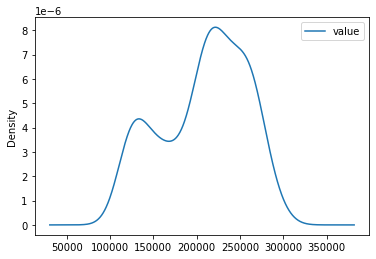

In [21]:
melted_data.plot(kind="kde", label=f"The Distribution of Average Home Prices")

This is a bimodal distribution. 
It  shows two distinct peaks, it suggests that there are two different groups or subpopulations within the ZipCode, each with its own characteristic home values. 

#### Time Series  Plots


We can plot the average home prices from April 1996 to APril 2018. 

<AxesSubplot:xlabel='time'>

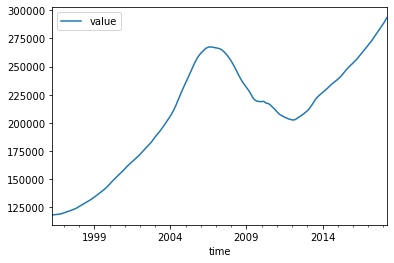

In [22]:
melted_data.plot()


House prices increased from 1996 to 2007, recording a drop from 2007 to 2011. The houses price then start to increase. 
The sudden decrease in 2007 is as a result of the housing market crisis of 2008 in the USA.  

#### Testing for Trends

The time series plot above shows signs of a linear trend. 
Linear trends defy the stationarity assumption assumed by most time series models.            
We need to test for the trends using Rolling statistics.   

We can plot the moving average and moving variance and see if it varies over time. 

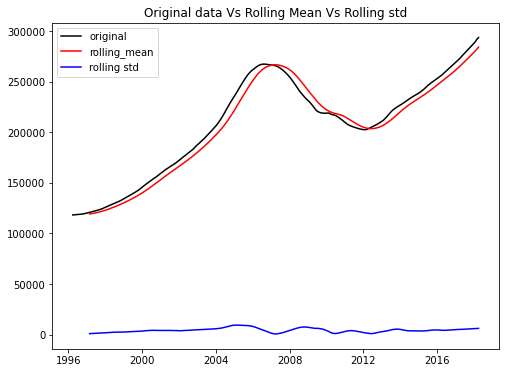

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
rolling_mean = melted_data.rolling(window=12,center=False).mean()
rolling_std = melted_data.rolling(window=12,center=False).std()

plt.plot(melted_data, color="black", label="original")
plt.plot(rolling_mean, color="red", label="rolling_mean")
plt.plot(rolling_std, color="blue", label="rolling std")
plt.title("Original data Vs Rolling Mean Vs Rolling std")
plt.legend()

The rolling mean is not stationary. Even thought the rolling std is close to being constant, this data does not look  stationary.     
We can carry out further tests to prove if our data is stationary:

In [24]:
dftest = adfuller(melted_data)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.574023
p-value                          0.496628
#Lags Used                      11.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


The test statistic is less than the critical value, we therefore fail to reject the null hypothesis. 
The data is not stationary

# DATA PROCESSING 

#### Removing the Trend.


We will try and make our time series data as stationary as possible. 


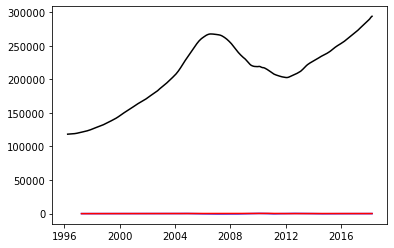

In [25]:

without_ewm = melted_data - melted_data.ewm(halflife=2).mean()
diffrenced = without_ewm.diff().dropna()
 

# fig, ax = plt.subplots(figsize=(8,6))
rolling_mean = diffrenced.rolling(window=12,center=False).mean()
rolling_std = diffrenced.rolling(window=12,center=False).std()

plt.plot(melted_data, color="black", label="Original")
plt.plot(rolling_mean, color="blue", label="Rolling Mean")
plt.plot(rolling_std, color="red", label="Rolling std")




In [26]:
dftest = adfuller(diffrenced)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -3.103739
p-value                          0.026278
#Lags Used                      10.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


The data is stationary in at 5% significance level. 


### AutoCorrelation Function
The autocorrelation function is a function that represents autocorrelation of a time series as a function of the time lag. 
ACF indicates how similar a value is within a given time series and the previous value. (OR) It measures the degree of the similarity between a given time series and the lagged version of that time series at the various intervals we observed

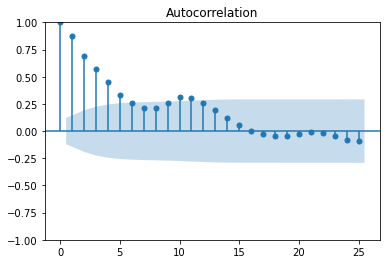

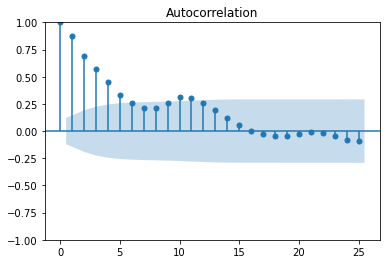

In [27]:
plot_acf(diffrenced)

### Partial Autocorrelation Function
Partial Autocorrelation Function (or PACF) gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags (unlike the autocorrelation function, which does not control for other lags).

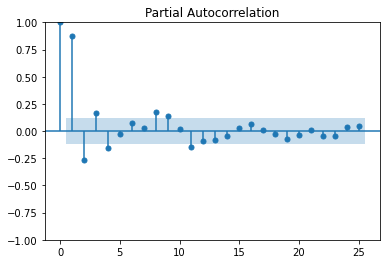

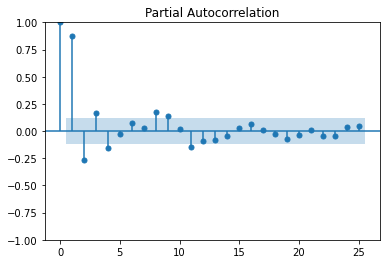

In [28]:
plot_pacf(diffrenced)

The high correlation ends at lag 2.          
The Gradually decreasing ACF and the instant drop in the PACF suggest that this may be an Autoregressive Model  AR(2), a lag of 2.           
Beyond two years, there is no correlation between the time series data. 

### Train Test Splitting the Data
When evaluating a model, it's important to simulate how the model would perform on unseen data.            
Train-test splitting helps achieve this by creating a clear distinction between the data used for training and the data used for testing

In [29]:
# Calculate the index to split the DataFrame
train_size = int(len(diffrenced) * 0.8)

# Split the DataFrame into training and test sets
train_set = diffrenced.iloc[:train_size]
test_set = diffrenced.iloc[train_size:]

# Print the lengths of the training and test sets
print(f"Training set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

Training set length: 211
Test set length: 53


The validation approach employed here is a train-test split. The dataset (diffrenced) is divided into two subsets: a training set (train_set) and a test set (test_set). The purpose of this division is to train the model on a portion of the data and evaluate its performance on a separate, unseen subset.

# MODELLING

### AUTOREGRESSIVE MODEL

This is when a value from a times series is regressed on previous values from the same series. 

In [32]:
model_arma = ARIMA(train_set, order=(2,0,0))
res_arma = model_arma.fit()
predicted_values = res_arma.predict(start=test_set.index[0], end=test_set.index[-1])
print(res_arma.summary())
rmse = sqrt(mean_squared_error(test_set, predicted_values))
mae =  mean_absolute_error(test_set, predicted_values)
print(rmse)
print(mae)

# test_set.plot()
# predicted_values.plot()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  211
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1250.901
Date:                Fri, 19 Jan 2024   AIC                           2509.802
Time:                        07:57:28   BIC                           2523.209
Sample:                    05-01-1996   HQIC                          2515.221
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3913     43.316      0.332      0.740     -70.507      99.290
ar.L1          1.2482      0.039     32.343      0.000       1.173       1.324
ar.L2         -0.3964      0.033    -11.899      0.0

This model gives us a RMSE of 102.09206.   and mae of 73.32           
This means that on average, the model's predictions are off by approximately 102 units.       
In the above model,  the parameters used were infered from the PACF and ACF with the assumption that the data was from an Auto Regressive Model.What if we were wrong?  

## Auto Arima

AutoARIMA is an automated version of the ARIMA (AutoRegressive Integrated Moving Average) model selection process.             
It systematically explores different combinations of ARIMA hyperparameters (p, d, q) to find the model that best fits the given time series data.         

In [33]:
arima_model = auto_arima(train_set,  seasonal=False ,suppress_warnings=True, stepwise=True)
predicted_values = arima_model.predict(n_periods=len(test_set))
rmse = sqrt(mean_squared_error(test_set, predicted_values))
mae =  mean_absolute_error(test_set, predicted_values)
print(rmse)
print(mae)

108.76929692195345
82.55236270709504


### SARIMAX MODEL

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) is an extension of the ARIMA model that includes additional features to account for external variables or exogenous factors that might influence the time series

In [34]:


# Use auto_arima to find the optimal parameters
arima_model = auto_arima(train_set, seasonal=True, m=5, D=1, suppress_warnings=True, stepwise=True)

# Extract the optimal order parameters
order = arima_model.get_params()['order']
seasonal_order = arima_model.get_params()['seasonal_order']

# Fit SARIMAX model with optimal parameters
sarimax_model = SARIMAX(train_set, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax_model.fit()

# Forecast future values
forecast = sarimax_fit.get_forecast(steps=len(test_set))

# Extract predicted values and true values
predicted_values = forecast.predicted_mean
true_values = test_set

# Calculate RMSE
rrmse = sqrt(mean_squared_error(test_set, predicted_values))
mae =  mean_absolute_error(test_set, predicted_values)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MAE): {mae}")


108.76929692195345
80.6140519821126


The model has a RMSE of 108.76 and a MAE of 80.61.  
On average, the model's predictions deviate from the actual values by approximately 108.76 units
The absolute difference between the model's predictions and the actual values is approximately 80.61 unit


How could our data perform with  advanced machine learning algorithms? We try Facebook Prophet. 

### FACEBOOK PROPHET


Prophet is an open-source forecasting tool developed by Facebook. It is designed to handle time series data and is particularly effective for datasets that exhibit strong seasonal patterns, holidays, and other recurring events. Prophet is capable of producing accurate forecasts while also providing users with an intuitive and user-friendly interface

We will first train the model with the differenced data to see how it compares with the previous models.

In [55]:
# import pandas as pd



# Use the train set for fitting the model
train_data = train_set.reset_index()
train_data.columns = ['ds', 'y']

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(train_data)

# Make a dataframe containing future dates for prediction
predict_df = prophet_model.make_future_dataframe(periods=len(test_set), freq='M', include_history=False)

# Obtain predictions for the observed period
predicted_values = prophet_model.predict(predict_df)

# Extract true values corresponding to the test set length
true_values = test_set.reset_index()

# Calculate RMSE
rmse = sqrt(mean_squared_error(true_values['value'], predicted_values["yhat"]))
mae = mean_absolute_error(true_values['value'], predicted_values["yhat"])

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Root Mean Squared Error (RMSE): {mae}")


08:34:42 - cmdstanpy - INFO - Chain [1] start processing


08:34:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 113.24774761322539
Root Mean Squared Error (RMSE): 85.21352883575531


The model has an RMSE of 113.247 and an mae of 85.
This is not bad compared to the baseline model rmse, we had, 102
However,  as noted before,  this is a powerful algorithm that works very well with raw data, handling outliers and automatic seasonality detection. 
We will therefore go ahead and try the model on raw data

In [ ]:
train, test = train_test_split(melted_data, test_size=0.2, shuffle=False)
train_data = train.reset_index()
train_data.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(train_data)
predict_df = prophet_model.make_future_dataframe(periods=len(test), freq='M', include_history=False)
predicted_values = prophet_model.predict(predict_df)
true_values = test.reset_index()
rmse = sqrt(mean_squared_error(true_values['value'], predicted_values["yhat"]))
print(f"Root Mean Squared Error (RMSE): {rmse}")


02:32:27 - cmdstanpy - INFO - Chain [1] start processing


02:32:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 48063.902522154196


The model has an RMSE of 48063. 


# EVALUATION

Root Mean Squared Error (RMSE) is a common metric for evaluating the accuracy of  models. It provides a measure of the average magnitude of the errors between predicted and actual values, and it is particularly sensitive to large errors. Lower RMSE values indicate better model performance, as it means the model's predictions are closer to the actual values.        
Mean Absolute Error on the other hand takes the absolute values or the difference between the predicted and the actual figures.  MAE is generally better at handling outliers  and is easily interpretable. 



Our best model  is the baseline model, Autogressive Model.      
It has a RMSE of 102.09 and a MAE of 73,32. 
It performs as follows compared to the other models:
 

In [58]:
pd.DataFrame({
    "columns" : ["autoregressive model", "auto arima", "sarimax", "prophet model"], 
    "rmse" : [102.09, 108.77, 108.8, 113.24],
    "mae": [73.3, 82.55, 80.61, 85.21] 
})

,columns,rmse,mae
0,autoregressive model,102.09,73.30
1,auto arima,108.77,82.55
2,sarimax,108.80,80.61
3,prophet model,113.24,85.21
